In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from preprocessed_mnist import load_dataset

Using TensorFlow backend.


In [2]:
# Get MNIST Data
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

(50000, 28, 28) (50000,)


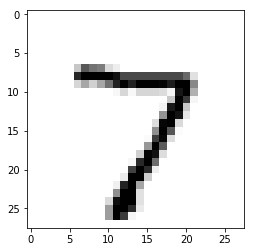

In [3]:
%matplotlib inline
plt.imshow(X_test[0], cmap="Greys");

In [23]:
# Initialize config vars
samples = X_train.shape[0]
features = X_train.shape[1]*X_train.shape[1]
classes = 10
batch = 64
neurons1 = 128
neurons2 = 128
epochs = 100
starter_learning_rate = 1e-4
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100, 85, staircase=True)
drop_val = 0.5
#momentum = 0.6

In [24]:
# Reshape MNIST features and One Hot Enconding y labels
with tf.Session() as sess:
    X_train_re = tf.reshape(X_train, (samples,features)).eval()
    Y_train_ohe = tf.one_hot(y_train, depth=classes).eval()

In [25]:
# Reshape MNIST features and One Hot Enconding y labels
with tf.Session() as sess:
    X_val_re = tf.reshape(X_val, (X_val.shape[0],features)).eval()
    Y_val_ohe = tf.one_hot(y_val, depth=classes).eval()

In [26]:
# Reshape MNIST features and One Hot Enconding y labels
with tf.Session() as sess:
    X_test_re = tf.reshape(X_test, (X_test.shape[0],features)).eval()
    Y_test_ohe = tf.one_hot(y_test, depth=classes).eval()

In [27]:
def init_vars():
    return tf.global_variables_initializer()

In [28]:
def init_weights(shape):
    '''Initialize weights with a defined shape
    '''
    #weights = tf.random_normal(shape, stddev=0.1)
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))

In [29]:
def forward_prop(x, weights, bias, activation=None):
    ''' Forward propagation
    '''
    z = tf.add(tf.matmul(x, weights),bias)
    if activation:
        y_hat = activation(z)
        return y_hat
    return z
    

In [30]:
# Iniatialize weights for hidden and output layer
w1 = init_weights((features,neurons))
w2 = init_weights((neurons1,neurons2))
w3 = init_weights((neurons2,classes))
b1 = init_weights((1,neurons1))
b2 = init_weights((1,neurons2))
b3 = init_weights((1,classes))

In [31]:
# Settign symbols
X_input = tf.placeholder(shape=(None,features), dtype=tf.float32)
Y_input = tf.placeholder(shape=(None,classes), dtype=tf.float32)
keep_prob = tf.placeholder(tf.float32)

In [32]:
# Forward propagation
y_hat = forward_prop(X_input,w1,b1,tf.nn.relu)
Y_hat = tf.nn.dropout(y_hat,keep_prob)
y_hat = forward_prop(y_hat,w2,b2,tf.nn.relu)
Y_hat = tf.nn.dropout(y_hat,keep_prob)
y_hat = forward_prop(y_hat,w3,b3)
predict = tf.argmax(y_hat, axis=1)

In [33]:
# Backward propagation
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=Y_input))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Epoch = 1, train_accuracy= 90.37%, test_acccuracy = 91.04%
Epoch = 2, train_accuracy= 92.62%, test_acccuracy = 92.95%
Epoch = 3, train_accuracy= 93.91%, test_acccuracy = 93.85%
Epoch = 4, train_accuracy= 94.71%, test_acccuracy = 94.40%
Epoch = 5, train_accuracy= 95.36%, test_acccuracy = 95.01%
Epoch = 6, train_accuracy= 95.80%, test_acccuracy = 95.49%
Epoch = 7, train_accuracy= 96.22%, test_acccuracy = 95.90%
Epoch = 8, train_accuracy= 96.54%, test_acccuracy = 96.16%
Epoch = 9, train_accuracy= 96.86%, test_acccuracy = 96.34%
Epoch = 10, train_accuracy= 97.09%, test_acccuracy = 96.53%
Epoch = 11, train_accuracy= 97.29%, test_acccuracy = 96.63%
Epoch = 12, train_accuracy= 97.52%, test_acccuracy = 96.74%
Epoch = 13, train_accuracy= 97.70%, test_acccuracy = 96.89%
Epoch = 14, train_accuracy= 97.85%, test_acccuracy = 97.02%
Epoch = 15, train_accuracy= 97.99%, test_acccuracy = 97.11%
Epoch = 16, train_accuracy= 98.16%, test_acccuracy = 97.08%
Epoch = 17, train_accuracy= 98.27%, test_acccurac

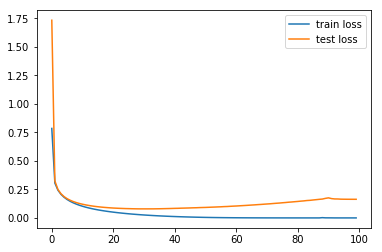

In [34]:
# Run Minibatch traning

%matplotlib inline
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(init_vars())
    
    # Initialize list to total store costs
    train_total_cost = []
    test_total_cost = []
    for epoch in range(epochs):
        
        # Initialize list to average store costs
        train_avg_cost = []
        test_avg_cost = []
        
        # Minibatch training
        for mb in range(0,len(X_train_re),batch):
            # Training and calculating cost
            _ , train_cost = sess.run([train, loss], feed_dict={X_input:X_train_re[mb:mb+batch], 
                                                                Y_input:Y_train_ohe[mb:mb+batch],
                                                                keep_prob: drop_val})
            train_avg_cost.append(train_cost)
            
            test_cost = sess.run(loss, feed_dict={X_input:X_test_re[mb:mb+batch], 
                                                  Y_input:Y_test_ohe[mb:mb+batch],
                                                  keep_prob: drop_val})
            test_avg_cost.append(test_cost)
            
        # Calculating accuracy    
        train_accuracy = np.mean(np.argmax(Y_train_ohe,axis=1)==
                                sess.run(predict, feed_dict={X_input: X_train_re, Y_input:Y_train_ohe}))
        test_acccuracy = np.mean(np.argmax(Y_test_ohe,axis=1)== 
                               sess.run(predict, feed_dict={X_input: X_test_re, Y_input:Y_test_ohe}))
        
        # Removing nan from test_avg_cost
        test_avg_cost = [x for x in test_avg_cost if str(x) != 'nan']
        
        # Calculating average train an test cost then append to total_cost
        train_total_cost.append(np.mean(train_avg_cost))
        test_total_cost.append(np.mean(test_avg_cost))
        

        print('Epoch = %d, train_accuracy= %.2f%%, test_acccuracy = %.2f%%' 
              % (epoch + 1, train_accuracy * 100.0, test_acccuracy * 100.0))
        
    #Plotting Train and Test loss
    plt.plot(range(len(train_total_cost)),train_total_cost, label='train loss')
    plt.plot(range(len(train_total_cost)),test_total_cost, label='test loss')
    plt.legend();
